In [0]:
import os
import time
import pandas as pd
import numpy as np
import nltk
import pickle
import json
import sys
sys.setrecursionlimit(10000000)
import re ### to use extended regex library: https://pypi.org/project/regex/
import ast
import csv
from bs4 import BeautifulSoup
import requests
import getpass
from urllib.request import urlopen
from google.colab import files

!pip install -U --pre matplotlib  ### we need 3.2 to use "addfont"

!pip install sddk ### our own package under construction, always install to have up-to-date version
import sddk

Requirement already up-to-date: matplotlib in /usr/local/lib/python3.6/dist-packages (3.2.0)


In [0]:
import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe

### authorize google sheets
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())
# establish connection with particular sheet by its url:

# RESULTS SPREADSHEET (dirgot_results)
sh = gc.open_by_url("https://docs.google.com/spreadsheets/d/1v99i42xd9jh0E9O_0-SrCrYE8WI91yQWB03BtJUm97w/edit?usp=sharing")

# sciencedata.dk configuration

As a data storage, we will use Danish official infrastructure called sciencedata.dk. It is commobly approacheble from any European research institution.

The configuration require having already a proper username and password configurated on the web interface of the platform.

In [0]:
conf = sddk.configure_session_and_url("dirgot_data", "648597@au.dk")

sciencedata.dk username (format '123456@au.dk'): kase@zcu.cz
sciencedata.dk password: ··········
connection with shared folder established with you as its ordinary user
endpoint variable has been configured to: https://sciencedata.dk/sharingout/648597%40au.dk/dirgot_data/


# Import the data

In [0]:
gospels_cleaned = sddk.read_file("gospels_cleaned.json", "dict", conf)
GNT_gospels_cleaned = sddk.read_file("GNT_gospels_cleaned.json", "dict", conf)

In [0]:
got_lines_data = sddk.read_file("got_lines_data.json", "df", conf)
got_codes_and_terms = sddk.read_file("got_codes_and_terms.json", "df", conf)

# Frequencies

In [0]:
all_words = []
for gospel in ["matt", "mark", "luke", "john", "thom"]: 
  gospel_list = gospels_cleaned[gospel]["words"]
  all_words.extend(gospel_list)

word_counts_total = nltk.FreqDist(all_words).most_common()
word_counts_total_dict = dict(word_counts_total)
TFs_total = {}
for word_count_tuple in word_counts_total:
  TFs_total.update({word_count_tuple[0] : round(word_count_tuple[1] / len(all_words), 5)})

In [0]:
gospels_TFs = {}
for gospel in ["matt", "mark", "luke", "john", "thom"]: 
  gospel_list = gospels_cleaned[gospel]["words"]
  word_counts = nltk.FreqDist(gospel_list).most_common()
  gospel_data = []
  for word_count_tuple in word_counts:
    gosTF = round(word_count_tuple[1] / len(gospel_list), 5)
    gos_to_corpTF = round(gosTF / TFs_total[word_count_tuple[0]], 5)
    gospel_data.append((word_count_tuple[0], gosTF, gos_to_corpTF))
  print(gospel_data[:50])
  gospels_TFs.update({gospel : gospel_data})

[('man', 0.0247, 1.18408), ('one', 0.02044, 1.05524), ('come', 0.01746, 0.83701), ('go', 0.01555, 1.17625), ('heaven', 0.01278, 1.87941), ('father', 0.01171, 0.72284), ('son', 0.01107, 0.99372), ('give', 0.01043, 0.89451), ('take', 0.01022, 1.05907), ('kingdom', 0.00916, 1.21809), ('see', 0.00788, 0.85652), ('day', 0.00745, 1.05524), ('servant', 0.00703, 1.42886), ('know', 0.00681, 0.67829), ('god', 0.0066, 0.59246), ('make', 0.00639, 1.04926), ('tell', 0.00639, 0.94807), ('receive', 0.00639, 1.15971), ('let', 0.00618, 1.00325), ('good', 0.00596, 1.13524), ('truly', 0.00596, 0.9298), ('lord', 0.00575, 1.40931), ('hear', 0.00554, 0.79942), ('away', 0.00532, 1.09465), ('also', 0.00532, 1.09465), ('hand', 0.00511, 1.25245), ('house', 0.00511, 0.97333), ('two', 0.0049, 1.4), ('evil', 0.00468, 1.64211), ('would', 0.00468, 1.07834), ('every', 0.00447, 1.35455), ('prophet', 0.00447, 1.53082), ('gather', 0.00447, 2.08879), ('many', 0.00426, 1.24198), ('do', 0.00426, 1.68379), ('master', 0.0042

In [0]:
matt_df = pd.DataFrame(gospels_TFs["matt"][:30], columns=["lemma", "gosTF", "gos_vs_corpTF"])
matt_df.head(5)

,lemma,gosTF,gos_vs_corpTF
0,man,0.02470,1.18408
1,one,0.02044,1.05524
2,come,0.01746,0.83701
3,go,0.01555,1.17625
4,heaven,0.01278,1.87941


# GNT sayings frequencies

In [0]:
all_words = []
for gospel in ["matt", "mark", "luke", "john"]: 
  gospel_list = GNT_gospels_cleaned[gospel][1]
  all_words.extend(gospel_list)

word_counts_total = nltk.FreqDist(all_words).most_common()
word_counts_total_dict = dict(word_counts_total)
GNT_TFs_total = {}
for word_count_tuple in word_counts_total:
  GNT_TFs_total.update({word_count_tuple[0] : round(word_count_tuple[1] / len(all_words), 5)})

In [0]:
GNT_gospels_TFs = {}
for gospel in ["matt", "mark", "luke", "john"]: 
  gospel_list = GNT_gospels_cleaned[gospel][1]
  word_counts = nltk.FreqDist(gospel_list).most_common()
  gospel_data = []
  for word_count_tuple in word_counts:
    gosTF = round(word_count_tuple[1] / len(gospel_list), 5)
    gos_to_corpTF = round(gosTF / GNT_TFs_total[word_count_tuple[0]], 5)
    gospel_data.append((word_count_tuple[0], gosTF, gos_to_corpTF))
  print(gospel_data[:50])
  GNT_gospels_TFs.update({gospel : gospel_data})

[('ἄνθρωπος', 0.01971, 1.20183), ('πᾶς', 0.01633, 1.02575), ('οὐρανός', 0.01434, 1.73398), ('ποιέω', 0.01215, 0.92748), ('ἔρχομαι', 0.01155, 0.79055), ('ὁράω', 0.01135, 0.96843), ('υἱός', 0.01135, 1.00442), ('πατήρ', 0.01115, 0.70929), ('κύριος', 0.00996, 1.19424), ('βασιλεία', 0.00976, 1.32249), ('γίνομαι', 0.00956, 1.02028), ('εἷς', 0.00936, 1.38667), ('ἔχω', 0.00936, 0.66242), ('τότε', 0.00816, 1.94286), ('δίδωμι', 0.00757, 0.72719), ('ἀφίημι', 0.00717, 1.16966), ('ἀκούω', 0.00697, 0.87125), ('θεός', 0.00657, 0.54478), ('ἕως', 0.00657, 1.40085), ('λαμβάνω', 0.00657, 1.2055), ('γῆ', 0.00637, 1.4), ('πολύς', 0.00637, 0.98302), ('ἡμέρα', 0.00637, 0.9437), ('θέλω', 0.00577, 1.14712), ('οὕτω', 0.00558, 1.37101), ('εἰσέρχομαι', 0.00558, 1.10934), ('δοῦλος', 0.00558, 1.41985), ('ὡς', 0.00538, 1.18242), ('πονηρός', 0.00518, 1.83039), ('βάλλω', 0.00518, 1.34197), ('ἀποκρίνομαι', 0.00498, 1.22359), ('δύο', 0.00498, 1.57098), ('εὑρίσκω', 0.00438, 1.26957), ('παραδίδωμι', 0.00418, 1.26284), ('ἐ

# Coptic frequencies

In [0]:
def check_dot(row):
  try:
    if "." in row["code"]:
      return True
    else:
      return False
  except:
    return True
got_codes_and_terms["dotted"] = got_codes_and_terms.apply(lambda row: check_dot(row), axis=1)

In [0]:
got_codes_and_terms = got_codes_and_terms[got_codes_and_terms["dotted"]==False]
got_codes_and_terms.drop(["dotted"], axis=1, inplace=True)
got_codes_and_terms.head(5)

,code,count,coptic,translation
7,1-536,116,"[ⲁⲩⲱ, ⲁⲩ-]",[and]
9,1-23,78,"[ⲣ-, ⲁⲁ=, ⲉⲓⲣⲉ, [ⲁ]ⲁ=, ⲟ+, ⲁ=, ⲉⲣⲓ-, [ⲓ]ⲣⲉ]","[act, become, befall, make, do, do!]"
11,1-365,68,[ϫⲉ],"[:, that, because, if, whether]"
16,2-174,47,"[ⲉⲃⲟⲗ, [ⲉⲃ]ⲟⲗ (?)]","[outward, forth, out]"
17,1-13,41,"[ϣⲟⲟⲡ+, ϣⲱⲡⲉ]","[be, exist, become]"


In [0]:
# merge
def merge_list(row, column):
  return "/".join(row[column])
got_codes_and_terms["coptic_merged"] = got_codes_and_terms.apply(lambda row: merge_list(row, "coptic"), axis=1)
got_codes_and_terms["translation_merged"] = got_codes_and_terms.apply(lambda row: merge_list(row, "translation"), axis=1)
got_codes_and_terms.head(10)

,code,count,coptic,translation,coptic_merged,translation_merged
7,1-536,116,"[ⲁⲩⲱ, ⲁⲩ-]",[and],ⲁⲩⲱ/ⲁⲩ-,and
9,1-23,78,"[ⲣ-, ⲁⲁ=, ⲉⲓⲣⲉ, [ⲁ]ⲁ=, ⲟ+, ⲁ=, ⲉⲣⲓ-, [ⲓ]ⲣⲉ]","[act, become, befall, make, do, do!]",ⲣ-/ⲁⲁ=/ⲉⲓⲣⲉ/[ⲁ]ⲁ=/ⲟ+/ⲁ=/ⲉⲣⲓ-/[ⲓ]ⲣⲉ,"act/become, befall/make, do/do!"
11,1-365,68,[ϫⲉ],"[:, that, because, if, whether]",ϫⲉ,:/that/because/if/whether
16,2-174,47,"[ⲉⲃⲟⲗ, [ⲉⲃ]ⲟⲗ (?)]","[outward, forth, out]",ⲉⲃⲟⲗ/[ⲉⲃ]ⲟⲗ (?),outward/forth/out
17,1-13,41,"[ϣⲟⲟⲡ+, ϣⲱⲡⲉ]","[be, exist, become]",ϣⲟⲟⲡ+/ϣⲱⲡⲉ,"be, exist/become"
19,1-674,37,"[ϣⲁⲛ-, ϣⲁ-, ⲉⲣϣⲁ-, ⲉⲣϣⲁⲛ-]","[if, when]",ϣⲁⲛ-/ϣⲁ-/ⲉⲣϣⲁ-/ⲉⲣϣⲁⲛ-,"if, when"
23,1-21,35,"[ⲣⲱⲙⲉ, ⲣⲙ-]",[human],ⲣⲱⲙⲉ/ⲣⲙ-,human
26,1-41,30,"[ϩⲉ, ϩⲉ-, ϩⲉⲉ]","[find, fall]",ϩⲉ/ϩⲉ-/ϩⲉⲉ,find/fall
28,1-57,27,"[ⲉⲓⲱⲧ, ⲓⲱⲧ]",[father],ⲉⲓⲱⲧ/ⲓⲱⲧ,father
29,1-33,27,"[ⲟⲩⲛ-, ⲟⲩⲛⲧⲏ=, ⲩⲛ-, ⲩⲛⲧⲁ=, ⲟⲩⲛⲧⲁ=, ⲩⲙ-, ⲩⲛⲧⲏ=]","[have, be]",ⲟⲩⲛ-/ⲟⲩⲛⲧⲏ=/ⲩⲛ-/ⲩⲛⲧⲁ=/ⲟⲩⲛⲧⲁ=/ⲩⲙ-/ⲩⲛⲧⲏ=,have/be


In [0]:
got_len = got_codes_and_terms["count"].sum()
got_len

2203

In [0]:
got_codes_and_terms["gosTF"] = got_codes_and_terms.apply(lambda row: np.round(row["count"]/got_len, 4), axis=1)

In [0]:
stopwords_coptic = ["1-536", "1-365", "2-174", "1-674", "2-8722", "1-1234", "2-3472", "1-139", "4-de", "4-otan", "2-3485", "4-gar", "4-alla", "4-ina", "4-oude"]
got_codes_and_terms = got_codes_and_terms[~got_codes_and_terms["code"].isin(stopwords_coptic)]

In [0]:
### for manual coding
### set_with_dataframe(sh.add_worksheet("got_codes_and_terms_MOSTCOMMON_raw", cols=1, rows=1), got_codes_and_terms[:30])

In [0]:
### after manual coding
got_codes_and_terms_short = get_as_dataframe(sh.worksheet("got_codes_and_terms_MOSTCOMMON"))
got_codes_and_terms_short

,code,count,coptic,translation,coptic_merged,lemma_trans,translation_merged,gosTF
0,1-23,78,"['ⲣ-', 'ⲁⲁ=', 'ⲉⲓⲣⲉ', '[ⲁ]ⲁ=', 'ⲟ+', 'ⲁ=', 'ⲉⲣ...","['act', 'become, befall', 'make, do', 'do!']",ⲣ-/ⲁⲁ=/ⲉⲓⲣⲉ/[ⲁ]ⲁ=/ⲟ+/ⲁ=/ⲉⲣⲓ-/[ⲓ]ⲣⲉ,ⲉⲓⲣⲉ (act/make),"act/become, befall/make, do/do!",0.0354
1,1-13,41,"['ϣⲟⲟⲡ+', 'ϣⲱⲡⲉ']","['be, exist', 'become']",ϣⲟⲟⲡ+/ϣⲱⲡⲉ,ϣⲱⲡⲉ (become),"be, exist/become",0.0186
2,1-21,35,"['ⲣⲱⲙⲉ', 'ⲣⲙ-']",['human'],ⲣⲱⲙⲉ/ⲣⲙ-,ⲣⲱⲙⲉ (man),human,0.0159
3,1-41,30,"['ϩⲉ', 'ϩⲉ-', 'ϩⲉⲉ']","['find', 'fall']",ϩⲉ/ϩⲉ-/ϩⲉⲉ,ϩⲉ (fall/find),find/fall,0.0136
4,1-57,27,"['ⲉⲓⲱⲧ', 'ⲓⲱⲧ']",['father'],ⲉⲓⲱⲧ/ⲓⲱⲧ,ⲉⲓⲱⲧ (father),father,0.0123
5,1-33,27,"['ⲟⲩⲛ-', 'ⲟⲩⲛⲧⲏ=', 'ⲩⲛ-', 'ⲩⲛⲧⲁ=', 'ⲟⲩⲛⲧⲁ=', '...","['have', 'be']",ⲟⲩⲛ-/ⲟⲩⲛⲧⲏ=/ⲩⲛ-/ⲩⲛⲧⲁ=/ⲟⲩⲛⲧⲁ=/ⲩⲙ-/ⲩⲛⲧⲏ=,ⲟⲩⲛ- (be),have/be,0.0123
6,1-5,25,"['ⲉⲓ', 'ⲓ']","['go', 'come', 'be about to']",ⲉⲓ/ⲓ,ⲉⲓ (come/go),go/come/be about to,0.0113
7,1-2,24,"['ϯ-', 'ϯ', 'ⲧⲁⲁ=', 'ⲙⲁ-', 'ⲙⲁ=']","['give', 'give!', 'sell']",ϯ-/ϯ/ⲧⲁⲁ=/ⲙⲁ-/ⲙⲁ=,ϯ (give/pay/sell),give/give!/sell,0.0109
8,1-55,23,"['ⲥⲟⲩⲱⲛ=', 'ⲥⲟⲩⲱⲛ-', 'ⲥⲟⲟⲩⲛ', 'ⲥⲟⲩⲱⲛ', 'ⲥⲟⲩⲛ-']",['know'],ⲥⲟⲩⲱⲛ=/ⲥⲟⲩⲱⲛ-/ⲥⲟⲟⲩⲛ/ⲥⲟⲩⲱⲛ/ⲥⲟⲩⲛ-,ⲥⲟⲟⲩⲛ (know),know,0.0104
9,1-123,22,"['ⲃⲱⲕ', 'ⲃⲏⲕ+']","['go, depart']",ⲃⲱⲕ/ⲃⲏⲕ+,ⲃⲱⲕ (go/depart),"go, depart",0.0100


# Frequencies visualizations

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import io
from PIL import Image

In [0]:
files.upload() #Antinoou.ttf
files.upload() #Quivira.otf

Output hidden; open in https://colab.research.google.com to view.

In [0]:
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('Antinoou.ttf')
mpl.font_manager.fontManager.addfont('Quivira.otf')


In [0]:
#from matplotlib import font_manager as fm, rcParams

#fpath = os.path.join(rcParams["datapath"], "Antinoou.ttf")
#prop = matplotlib.font_manager.FontProperties(fname=fpath)
#fname = os.path.split(fpath)[1]

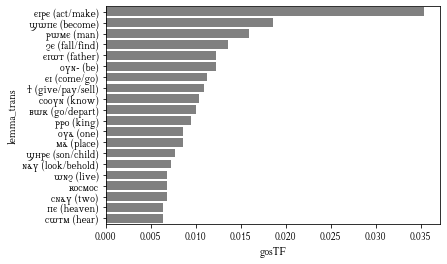

In [0]:
mpl.rc('font', family='Quivira')

gospel_df = got_codes_and_terms_short[:20]
xcol=gospel_df["gosTF"]
ycol=gospel_df["lemma_trans"]

#plt.rcParams["font.family"] = font_families[34]
sns.barplot(x=xcol, y=ycol,color="gray")

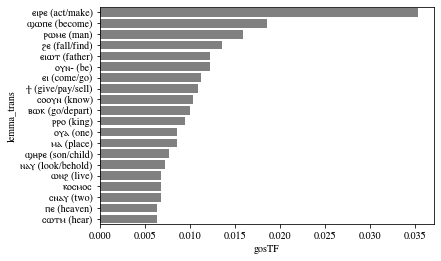

In [0]:
mpl.rc('font', family='Antinoou')

gospel_df = got_codes_and_terms_short[:20]
xcol=gospel_df["gosTF"]
ycol=gospel_df["lemma_trans"]

#plt.rcParams["font.family"] = font_families[34]
sns.barplot(x=xcol, y=ycol,color="gray")

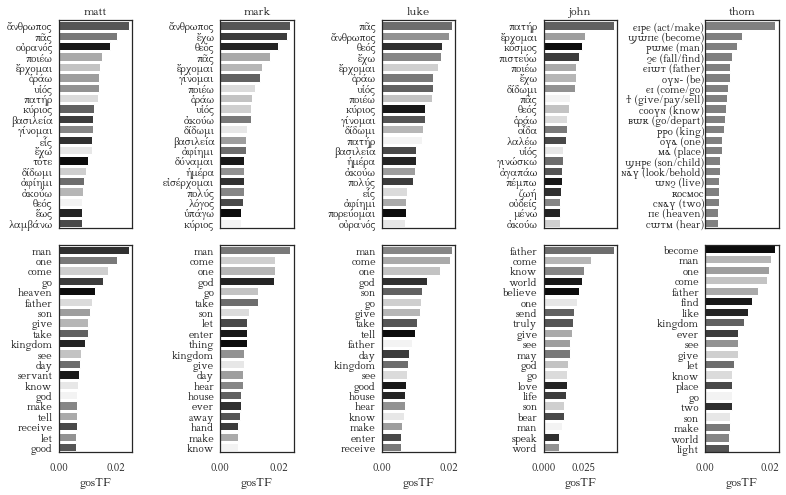

In [0]:
plt.rcParams['figure.figsize'] = [10, 6]
sns.set(style="white", font="Quivira")
#mpl.rc('font', family='Antinoou')
#fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

fig, ([ax1, ax2, ax3, ax4, ax5], [ax6, ax7, ax8, ax9, ax10]) = plt.subplots(2, 5)

### 4 GNT 
for gospel_plot in zip(["matt", "mark", "luke", "john"], [ax1, ax2, ax3, ax4]):
  gospel_df = pd.DataFrame(GNT_gospels_TFs[gospel_plot[0]][:20], columns=["lemma", "gosTF", "gos_vs_corpTF"])
  xcol=gospel_df["gosTF"]
  ycol=gospel_df["lemma"]
  pal = sns.color_palette("gray", len(gospel_df))
  rank = gospel_df["gos_vs_corpTF"].argsort().argsort()   # http://stackoverflow.com/a/6266510/1628638
  sns.barplot(x=xcol, y=ycol, palette=np.array(pal[::-1])[rank], ax=gospel_plot[1])
  gospel_plot[1].set_title(gospel_plot[0])
  gospel_plot[1].set(ylabel="")
  gospel_plot[1].tick_params(axis="y", pad=0)
  gospel_plot[1].axes.get_xaxis().set_visible(False)
  plt.margins(y=0)
  plt.tight_layout()


### COPTIC GOT
gospel_df = got_codes_and_terms_short[:20]
xcol=gospel_df["gosTF"]
ycol=gospel_df["lemma_trans"]
sns.barplot(x=xcol, y=ycol, color="gray", ax=ax5)
ax5.set_title("thom")
ax5.tick_params(axis="y", pad=-5)
ax5.axes.get_xaxis().set_visible(False)
ax5.set(ylabel="")
ax5.axes.get_xaxis().set_visible(False)
plt.margins(y=0)
plt.tight_layout()

### 5 GOSPELS IN ENGLISH
for gospel_plot in zip(["matt", "mark", "luke", "john", "thom"], [ax6, ax7, ax8, ax9, ax10]):
  gospel_df = pd.DataFrame(gospels_TFs[gospel_plot[0]][:20], columns=["lemma", "gosTF", "gos_vs_corpTF"])
  xcol=gospel_df["gosTF"]
  ycol=gospel_df["lemma"]
  pal = sns.color_palette("gray", len(gospel_df))
  rank = gospel_df["gos_vs_corpTF"].argsort().argsort()   # http://stackoverflow.com/a/6266510/1628638
  sns.barplot(x=xcol, y=ycol, palette=np.array(pal[::-1])[rank], ax=gospel_plot[1]) 
  gospel_plot[1].set_title(gospel_plot[0])
  gospel_plot[1].tick_params(axis="y", pad=0)
  gospel_plot[1].set(ylabel="")
  plt.margins(y=0)
  plt.tight_layout()


#ax5.axis('off')
for subplot in [ax6, ax7, ax8, ax9, ax10]:
  subplot.set_title("")

plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.08, wspace=1.2)
plt.savefig("TF_overview_new.png", bbox_inches="tight")
#files.download("TF_overview_.png") ### uncomment to manually download the image

In [0]:
files.download("TF_overview_new.png") ### uncomment to manually download the image

# Distances

In [0]:
### all five  gospels in english
gospels_jesus_lemmatized = []
for gospel in ["matt", "mark", "luke", "john", "thom"]:
  gospels_jesus_lemmatized.append(" ".join(gospels_cleaned[gospel]["words"]))


can_gospels = ["matt", "mark", "luke", "john"]
### four canonical in English
can_gospels_en = []
for gospel in can_gospels:
  can_gospels_en.append(" ".join(gospels_cleaned[gospel]["words"]))

### four canonical in Greek
can_gospels_gr = []
for gospel in can_gospels:
  can_gospels_gr.append(" ".join(GNT_gospels_cleaned[gospel][1]))

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD 
from sklearn.metrics.pairwise import cosine_similarity

# make the
def make_vec_df(list_of_string_docs, doc_names):
  vec = CountVectorizer()
  X = vec.fit_transform(list_of_string_docs)
  vectorization_df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names(), index=doc_names)
  cosine_sim = cosine_similarity(X.toarray()) 
  cosine_sim_df = pd.DataFrame(np.round(cosine_sim, 5), columns=doc_names, index=doc_names)
  cosine_dist = 1 - cosine_similarity(X.toarray())
  cosine_dist_df = pd.DataFrame(np.round(cosine_dist, 5), columns=doc_names, index=doc_names)
  return [vectorization_df, cosine_sim_df, cosine_dist_df, doc_names]

In [0]:
five_en_simdist = make_vec_df(gospels_jesus_lemmatized, ["matt", "mark", "luke", "john", "thom"])
can_en_simdist = make_vec_df(can_gospels_en, can_gospels)
can_gr_simdist = make_vec_df(can_gospels_gr, can_gospels)

In [0]:
### RSV distances
can_en_simdist[2]

,matt,mark,luke,john
matt,-0.00000,0.11877,0.08327,0.32564
mark,0.11877,-0.00000,0.11102,0.35930
luke,0.08327,0.11102,0.00000,0.31936
john,0.32564,0.35930,0.31936,0.00000


In [0]:
### GNT distances
can_gr_simdist[2]

,matt,mark,luke,john
matt,-0.00000,0.13911,0.10188,0.36540
mark,0.13911,0.00000,0.12776,0.35486
luke,0.10188,0.12776,-0.00000,0.32708
john,0.36540,0.35486,0.32708,-0.00000


In [0]:
### RSV + GoT distances
five_en_simdist[2]

,matt,mark,luke,john,thom
matt,-0.00000,0.11877,0.08327,0.32564,0.23857
mark,0.11877,-0.00000,0.11102,0.35930,0.28595
luke,0.08327,0.11102,0.00000,0.31936,0.24163
john,0.32564,0.35930,0.31936,0.00000,0.40978
thom,0.23857,0.28595,0.24163,0.40978,-0.00000


In [0]:
### do the similarities correlate?
from scipy.stats import pearsonr

can_en_flatten = can_en_simdist[1].values.flatten().tolist()
can_gr_flatten = can_gr_simdist[1].values.flatten().tolist()

cor = pearsonr(can_en_flatten, can_gr_flatten)
print(round(cor[0], 5), round(cor[1], 5))

0.99564 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/manifold/mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
/usr/local/lib/python3.6/dist-packages/sklearn/manifold/mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
/usr/local/lib/python3.6/dist-packages/sklearn/manifold/mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


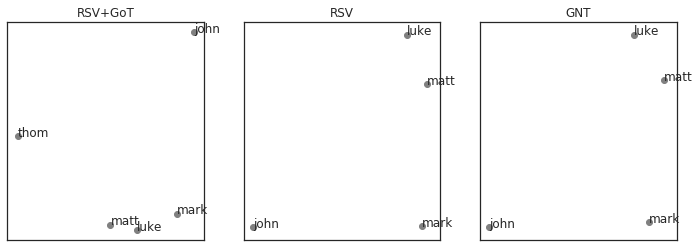

In [0]:
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

plt.rcParams['figure.figsize'] = (12.0, 4.0)
plt.rcParams.update({'font.size': 12})

mds = MDS(n_components=2, random_state=1) # dissimilarity="precomputed",


fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
for ax_dist in zip([ax1, ax2, ax3], [five_en_simdist, can_en_simdist, can_gr_simdist], ["RSV+GoT", "RSV", "GNT"]):
  # we need to transform the indovidual distances into a 2-dimensional space
  #mds = MDS(n_components=2, dissimilarity="precomputed", random_state=0)
  pos = mds.fit_transform(ax_dist[1][2])
  xs, ys = pos[:, 0], pos[:, 1]
  # to have the plot big enough, we will modify default size of all generated plots
  # (original is 6 to 4 inches)
  #fig = plt.figure()
  # now we can plot the distances transformed via the mds function as a scatter plot
  for x, y, name in zip(xs, ys, ax_dist[1][2].columns):
      color = "grey"
      ax_dist[0].scatter(x, y, c=color)
      ax_dist[0].text(x, y, name)
  ax_dist[0].set_title(ax_dist[2])
  ax_dist[0].axes.get_xaxis().set_visible(False)
  ax_dist[0].axes.get_yaxis().set_visible(False)


#fig.savefig("distances_2D.png", bbox_inches="tight", dpi=fig.dpi)

In [0]:
### make a temporal file
fig.savefig("distances_2D.png", bbox_inches="tight", dpi=fig.dpi) 

In [0]:
### save the temporal file locally
files.download("distances_2D.png") ### uncomment to manually download the image

In [0]:
s.put(sciencedata_groupurl + "dirgot_data/distances_2D.png", data = open("distances_2D.png", 'rb'))

<Response [204]>

In [0]:
files.download("distances_2D.png") ### uncomment to manually download the image